## Proyect 1 Understanding calibration in CNNs

Students
*Álex Sánchez Zurita*
*Jorge Barcenilla Gonzalez*
*Santiago Prieto Núñez*

In this lab, you will investigate the calibration convolutional CNNs in a classification setting:
- Read the paper "On calibration on modern neural networks," particularly sections 1 to 4
- Train a Lenet5 CNN from scratch to classify birds from cats in CIFAR10. Namely, we only consider two categories. Evaluate the reliability diagram and the ECE in the test set. You have methods for this in sklearn.
- Implement a basic temperature scaling (Platt's scaling), where the output probability p(zi) (being zi the logit) is modified by p(az_i), where a is a constant chosen to smooth the output probabilities. Study the effect of parameter 
a- Plot the reliability diagram and the ECE after applying the scaling.
(Optional, adds 0.25 additional points to the project grade) - Repeat the same experiment for a much bigger model obtained after fine-tuning a pre-trained model's last classification layer. Note that if you use a model pre-trained over a different database, you probably have to re-adapt the input dimensionality.
- Upload a zip file with a 3-page report with your main results and code for your experiments. The code can be a Python script or a Jupyter Notebook.
- You can work in groups of up to three. Each of you has to upload the solution to Aula Global!
- **Deadline is October 20, at 23:59**

## Analize the dataset


Number of images per class:
Train: {'bird': 5000, 'cat': 5000}
Test:  {'bird': 1000, 'cat': 1000}


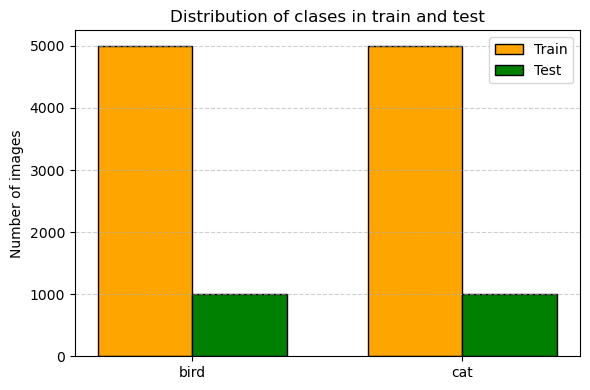

In [10]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Model and dataset variables
DATA_DIR = './data'
BATCH_SIZE = 32
NUM_EPOCH = 35
CV_PARAMS = False       # get the best params for train tools


# Transform the data to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 1-- Load the folders with the datsets
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=transform)
classes = train_dataset.classes

# Count the imáges of each class
def count_images(dataset):
    counts = {cls: 0 for cls in classes}
    for _, label in dataset:
        counts[classes[label]] += 1
    return counts

train_counts = count_images(train_dataset)
test_counts = count_images(test_dataset)

print("\nNumber of images per class:")
print(f"Train: {train_counts}")
print(f"Test:  {test_counts}")

# 2-- Plot the clases proportions
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(classes))
width = 0.35

ax.bar(x - width/2, list(train_counts.values()), width, label='Train', color='orange', edgecolor='black')
ax.bar(x + width/2, list(test_counts.values()), width, label='Test', color='green', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of images')
ax.set_title('Distribution of clases in train and test')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

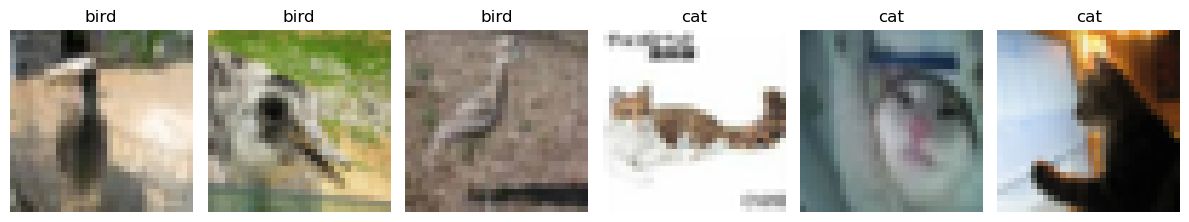

In [11]:
import random
from PIL import Image

# Show a sample of the images in the dataset
def show_images_from_dirs(base_dir, classes, n_images=4):
    img_paths = []
    labels = []

    # get the image paths
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        all_images = os.listdir(class_dir)

        # get a random sample of images
        selected_images = random.sample(all_images, min(int(n_images/len(classes)), len(all_images)))
        for img_name in selected_images:
            img_paths.append(os.path.join(class_dir, img_name))
            labels.append(cls)

    n_images = len(img_paths)
    plt.figure(figsize=(2 * n_images, 4))

    for i, path in enumerate(img_paths):
        img = Image.open(path)  # abrir imagen
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])

    plt.tight_layout()
    plt.show()

base_dir = './data/train'
classes = ['bird', 'cat']
show_images_from_dirs(base_dir, classes, n_images=6)

Finally we must change the classes from "bird" and "cat" to 0 and 1 to classify

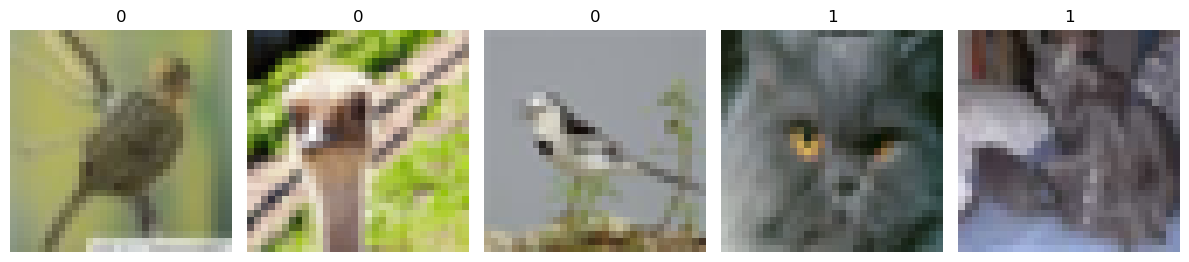

In [12]:
# filter dataset clases
train_dataset.targets = [0 if t==2 else 1 for t in train_dataset.targets]
test_dataset.targets = [0 if t==2 else 1 for t in test_dataset.targets]

# show 5 random images with its new class
indices = random.sample(range(len(train_dataset)), 5)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = img / 2 + 0.5  # convert orig from [-1,1] to [0,1]
    npimg = img.numpy()
    
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.title(label)  # show label

plt.tight_layout()
plt.show()


## Model definition

We can make the model following the original arquitecture of *Yann LeCun* in 
["GradientBased Learning Applied to Document Recognition"](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf).
In the pag 7 we can follow a detailed descripiton of each layer component

## Modern LeNet5 Architecture

The modernized LeNet5 architecture includes the following improvements:

### Key Changes:
1. **MaxPooling instead of Subsampling**: Replaced trainable subsampling layers with standard MaxPooling layers (2x2, stride=2)
2. **Batch Normalization**: Added BatchNorm2d layers after each convolution for better training stability
3. **Increased Filter Sizes**: More filters per layer (32→64→128 instead of 6→16→120)
4. **Dropout Regularization**: Added dropout layers (p=0.5) in the classifier to prevent overfitting
5. **ReLU Activations**: Using ReLU instead of sigmoid/tanh for better gradient flow
6. **Proper Weight Initialization**: Kaiming normal initialization for conv layers, appropriate for ReLU activations
7. **Adam Optimizer**: Using Adam optimizer instead of SGD for better convergence

### Architecture Details:
- **Input**: 3x32x32 (CIFAR-10 RGB images)  
- **Conv1**: 32 filters, 5x5 kernel, padding=2 → BatchNorm → ReLU → MaxPool(2x2)
- **Conv2**: 64 filters, 5x5 kernel, padding=2 → BatchNorm → ReLU → MaxPool(2x2)  
- **Conv3**: 128 filters, 3x3 kernel, padding=1 → BatchNorm → ReLU → MaxPool(2x2)
- **Classifier**: Dropout → FC(2048→512) → ReLU → Dropout → FC(512→128) → ReLU → FC(128→2)

This modern architecture should provide better performance and faster convergence compared to the original LeNet5.

In [13]:
import torch.nn as nn

# first we get the data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Modern LeNet5 with MaxPooling and improved architecture
class ModernLeNet5(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super().__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(input_channels, 32, kernel_size=5, padding=2),  # 32x32 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            
            # Second convolutional block  
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # 16x16 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 8x8 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
        )
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Original subsampling class for reference (kept for original LeNet5)
class Subsampling(nn.Module):
    """Subsampling entrenable como en LeNet-5 original"""
    def __init__(self, num_features):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(num_features,1,1))  # training coefficient
        self.bias = nn.Parameter(torch.zeros(num_features,1,1))  # bias

    def forward(self, x):
        # get the 2x2 blocks without overlap
        patches = x.unfold(2,2,2).unfold(3,2,2)
        # sum each element of the 4 blocks
        x = patches.sum(dim=-1).sum(dim=-1)
        # multuiply by the learned coefficient and sum the bias
        return torch.sigmoid(x * self.scale + self.bias)

# Original LeNet5 architecture (kept for reference)
class LeNet5_Original(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        # C1: Conv 5x5, 6 filters
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5)
        # S2: Subsampling layer with 6 maps
        self.s2 = Subsampling(6)
        # C3: Conv 5x5, 16 filtros (simplificado: conectado a todos)
        self.conv3 = nn.Conv2d(6,16, kernel_size=5)
        # S4: Subsampling entrenable
        self.s4 = Subsampling(16)
        # C5: Conv fully connected, 120 neuronas
        self.conv5 = nn.Conv2d(16, 120, kernel_size=5)
        # F6: fully connected, 84 neuronas
        self.fc6 = nn.Linear(120, 84)
        # Output
        self.fc7 = nn.Linear(84, num_classes)

    def forward(self, x):
        # C1 -> S2
        x = self.conv1(x)
        x = torch.relu(x)       # Originaly a Sigmoid activation of C1
        x = self.s2(x)
        # C3 -> S4
        x = self.conv3(x)
        x = torch.relu(x)       # Originaly a Sigmoid
        x = self.s4(x)
        # C5
        x = self.conv5(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)  # flatten for fully connected
        # F6 -> Output
        x = torch.relu(self.fc6(x))  # Originaly a Sigmoid for MLP f6
        x = self.fc7(x)
        return x

## Train model
Once defined the model we train it

In [14]:
import random
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import torch.optim as optim


def grid_optim(model, train_loader, params: dict, n_samples = 2000):
    """
    Get the best parameters for the model using CV_grid search.
    We use the train dataset
        model: neural network used
        train_loader: dataloader for train
        params: dictionary with the params of model
        device: 'cuda' or 'cpu'
        n_samples: number of images to do the grid search
    """

    # wrap of skorch to do the grid search of all model
    net = NeuralNetClassifier(
        model,
        max_epochs=5,                 # few epoch to optimize the cv
        lr=0.001,                     # Default Adam learning rate
        optimizer=optim.Adam,         # Changed from SGD to Adam
        batch_size=64,
        criterion=nn.CrossEntropyLoss,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # get the data of dataloader
    X_train = torch.cat([x for x, _ in train_loader])
    y_train = torch.cat([y for _, y in train_loader])

    # get a subsample of the data
    idx = random.sample(range(len(test_dataset)), n_samples)
    X_sub = X_train[idx]
    y_sub = y_train[idx]

    # Do the gridsearch
    gs = GridSearchCV(
        estimator=net,
        param_grid=params,
        scoring='accuracy',
        cv=5,               # 5 folds
        refit=True,
        verbose=2
    ).fit(X_sub, y_sub)

    # Show the results and return the best optimizer
    print("✅ Best parameters:", gs.best_params_)
    print("🎯 Best optimizer accuracy:", gs.best_score_)
    
    # Create Adam optimizer with best parameters
    best_optim = optim.Adam(model.parameters(),
                           lr=gs.best_params_["lr"],
                           weight_decay=gs.best_params_.get("optimizer__weight_decay", 0),
                           betas=(gs.best_params_.get("optimizer__beta1", 0.9), 
                                 gs.best_params_.get("optimizer__beta2", 0.999)))

    return best_optim

In [15]:
import torch.optim as optim

# First we need to define the enviroment of the train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📦 Using device:", device)

# Create a model of the Modern LeNet5 arquitecture
model = ModernLeNet5(input_channels=3, num_classes=2).to(device) # upload to GPU/CPU

# define the loss function
loss = nn.CrossEntropyLoss()

# get the best parámeters with a grid search
if CV_PARAMS:
    parameters = {
        'lr': [0.001, 0.0001, 0.01],                        # Adam learning rates
        'optimizer__weight_decay': [0, 1e-5, 1e-4],        # L2 regularization
        'optimizer__beta1': [0.9, 0.95],                   # Adam beta1 parameter
        'optimizer__beta2': [0.999, 0.9999]                # Adam beta2 parameter
    }
    optimizer = grid_optim(model, train_loader, parameters)
else:   # no search for hyperparámeters - use Adam defaults
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

📦 Using device: cuda
📊 Model parameters: 1,243,010
📊 Trainable parameters: 1,243,010


In [16]:
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split

# Create validation split from training data for proper scheduler monitoring
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create validation loader
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
train_subset_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)

# Define the learning rate scheduler BEFORE training loop
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# metrics and info of train
train_loss = []
train_acc = []
val_loss_history = []
val_acc_history = []
lr_history = []

print(f"📊 Training on {len(train_subset)} samples, validating on {len(val_subset)} samples")

for epoch in range(NUM_EPOCH):
    # TRAINING PHASE
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_subset_loader:
        # Move batch to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Reset optimizer
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss_val = loss(outputs, targets)
        
        # Backward pass
        loss_val.backward()
        optimizer.step()
        
        # Get accuracy and metrics
        epoch_loss += loss_val.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
    
    train_loss.append(epoch_loss / total)
    train_acc.append(correct / total)
    
    # VALIDATION PHASE
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss_val = loss(outputs, targets)
            
            val_loss += loss_val.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    # Update scheduler 
    scheduler.step(val_loss)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCH} - Train Loss: {train_loss[epoch]:.4f} - Train Acc: {train_acc[epoch]:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} - LR: {current_lr:.6f}")

# FINAL TEST EVALUATION
correct = 0
total = 0
test_loss = 0

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        loss_val = loss(outputs, targets)
        test_loss += loss_val.item() * inputs.size(0)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

test_acc = correct / total
test_loss /= total

print(f"\n🚀 Final Test Results:")
print(f"Loss:\t{test_loss:.4f}")
print(f"Accuracy:\t{test_acc:.4f}")
print(f"🔧 Final Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
print(f"📉 Learning Rate Reductions: {len([lr for i, lr in enumerate(lr_history[1:], 1) if lr < lr_history[i-1]])}")

📊 Training on 8000 samples, validating on 2000 samples


c:\Users\alexs\miniconda3\envs\isic2\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/35 - Train Loss: 0.5428 - Train Acc: 0.7339 - Val Loss: 0.5057 - Val Acc: 0.7505 - LR: 0.001000
Epoch 2/35 - Train Loss: 0.4701 - Train Acc: 0.7830 - Val Loss: 0.4494 - Val Acc: 0.7955 - LR: 0.001000
Epoch 2/35 - Train Loss: 0.4701 - Train Acc: 0.7830 - Val Loss: 0.4494 - Val Acc: 0.7955 - LR: 0.001000
Epoch 3/35 - Train Loss: 0.4278 - Train Acc: 0.8043 - Val Loss: 0.4520 - Val Acc: 0.8155 - LR: 0.001000
Epoch 3/35 - Train Loss: 0.4278 - Train Acc: 0.8043 - Val Loss: 0.4520 - Val Acc: 0.8155 - LR: 0.001000
Epoch 4/35 - Train Loss: 0.4000 - Train Acc: 0.8251 - Val Loss: 0.4581 - Val Acc: 0.8020 - LR: 0.001000
Epoch 4/35 - Train Loss: 0.4000 - Train Acc: 0.8251 - Val Loss: 0.4581 - Val Acc: 0.8020 - LR: 0.001000
Epoch 5/35 - Train Loss: 0.3610 - Train Acc: 0.8410 - Val Loss: 0.3996 - Val Acc: 0.8195 - LR: 0.001000
Epoch 5/35 - Train Loss: 0.3610 - Train Acc: 0.8410 - Val Loss: 0.3996 - Val Acc: 0.8195 - LR: 0.001000
Epoch 6/35 - Train Loss: 0.3338 - Train Acc: 0.8569 - Val Loss: 

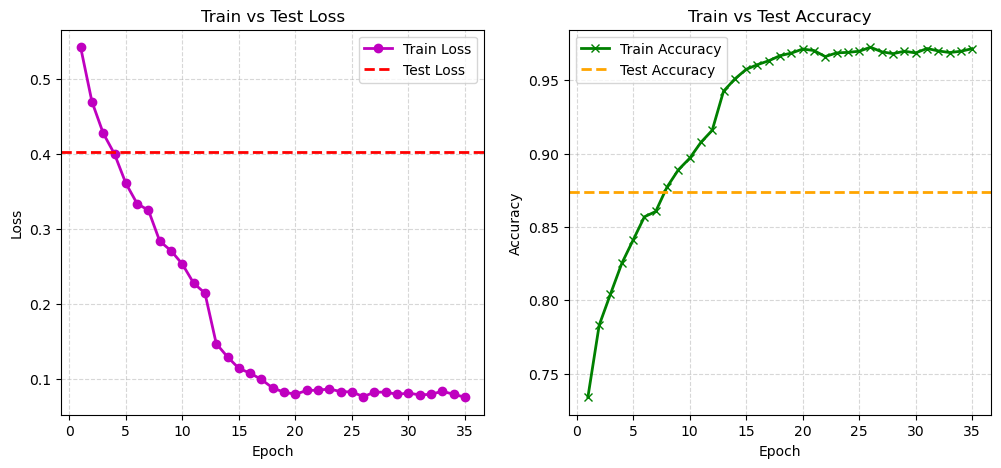

In [17]:
epochs = np.arange(1, NUM_EPOCH+1)

# --- Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'm-o', label='Train Loss', linewidth=2)
plt.axhline(y=test_loss, color='red', linestyle='--', linewidth=2, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'g-x', label='Train Accuracy', linewidth=2)
plt.axhline(y=test_acc, color='orange', linestyle='--', linewidth=2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

📊 Validation set predictions collected: 2000 samples
🎯 Original Model ECE: 0.0719
🌡️ Optimal Temperature (parameter 'a'): 2.2858

📊 Temperature Scaling Results (Effect of parameter 'a'):
   temperature_a     ece  accuracy  brier_score  mean_confidence
0         0.5000  0.0941    0.8885       0.0993           0.9822
1         0.8000  0.0812    0.8885       0.0932           0.9697
2         1.0000  0.0719    0.8885       0.0899           0.9604
3         1.5000  0.0461    0.8885       0.0842           0.9346
4         2.0000  0.0264    0.8885       0.0817           0.9068
5         2.2858  0.0139    0.8885       0.0815           0.8909
6         3.0000  0.0426    0.8885       0.0834           0.8528
7         5.0000  0.1212    0.8885       0.0991           0.7673

🏆 Best Temperature 'a' (lowest ECE): 2.2858


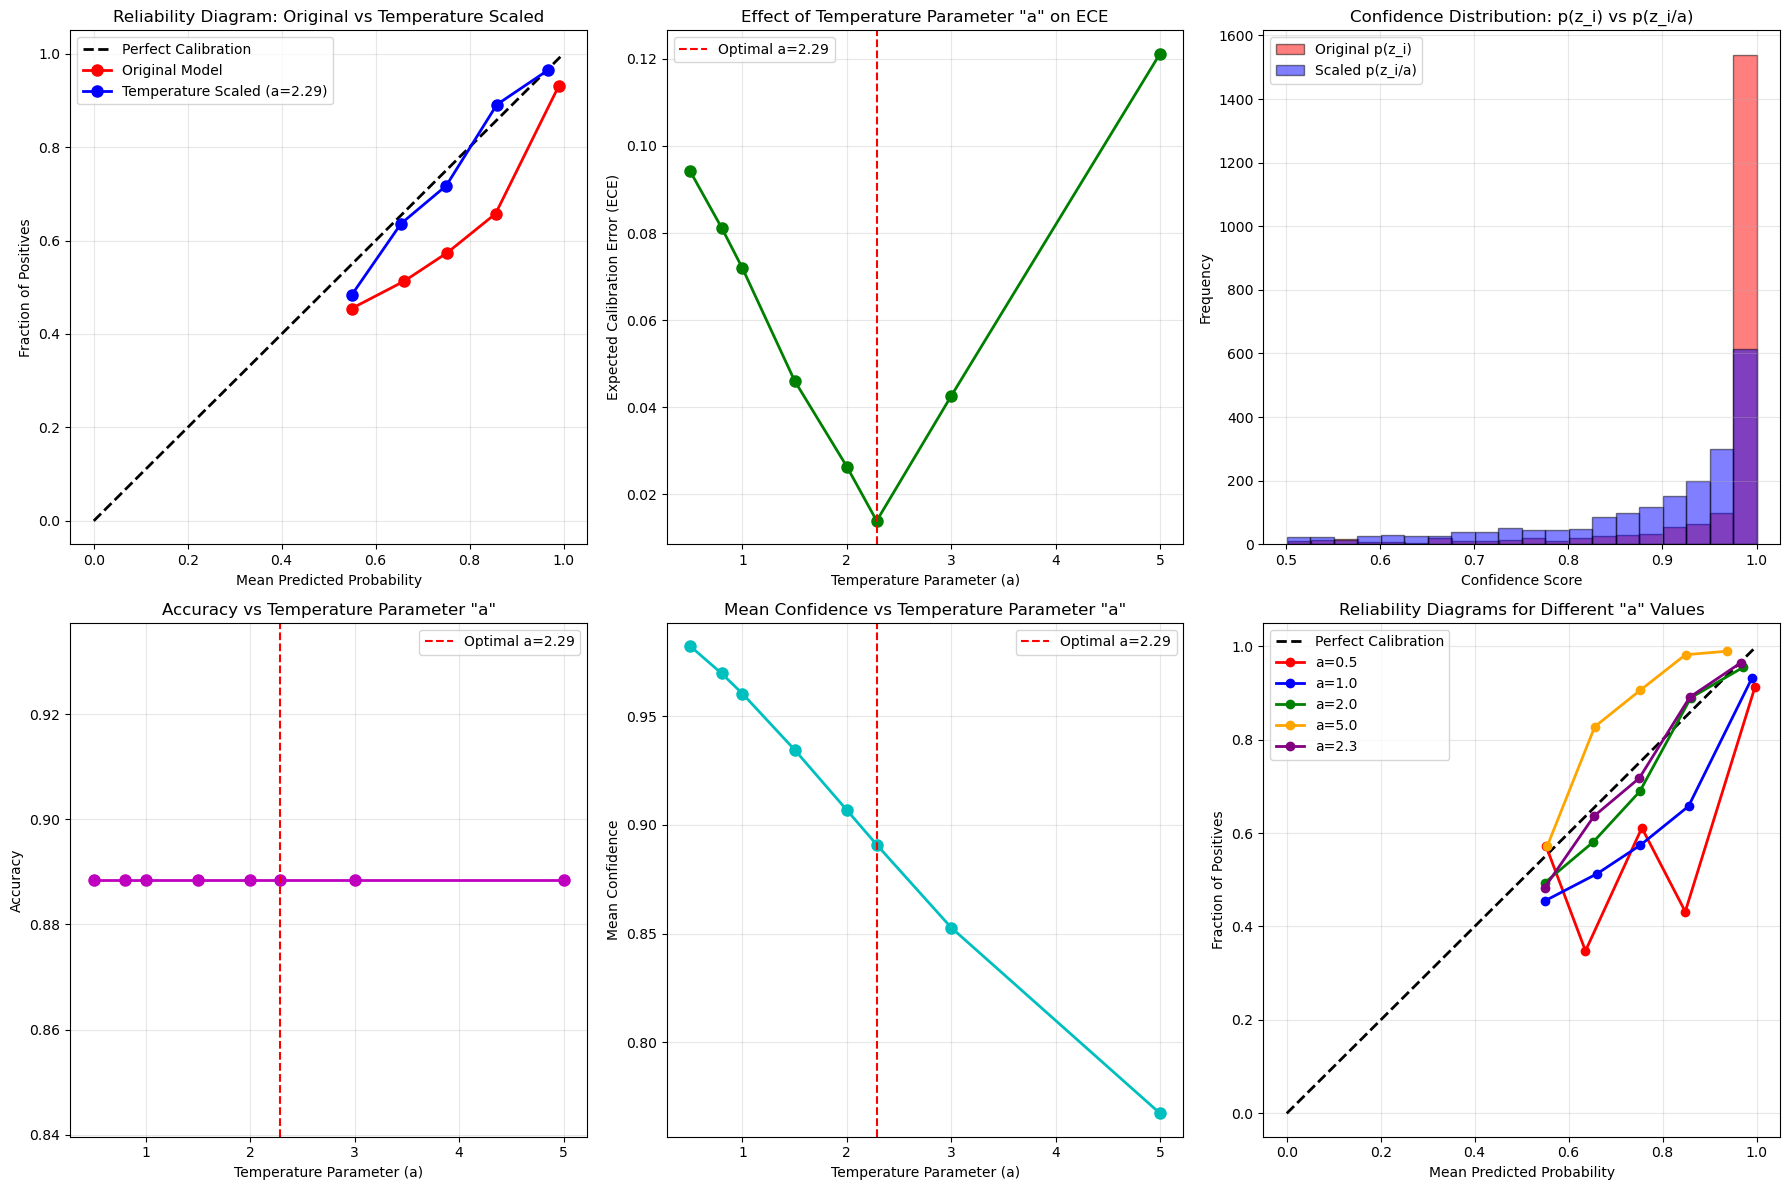


🎯 TEMPERATURE SCALING (PLATT'S SCALING) ANALYSIS SUMMARY
📊 Original Model p(z_i):
   • ECE: 0.0719
   • Accuracy: 0.8885
   • Mean Confidence: 0.9604

📊 Temperature Scaled Model p(z_i/a) where a=2.2858:
   • ECE: 0.0139
   • Accuracy: 0.8885
   • Mean Confidence: 0.8909
   • Brier Score: 0.0815

📈 Improvements:
   • ECE Reduction: 80.6%
   • Better Calibrated: ✅ Yes

🌡️ Temperature Parameter 'a' Effect:
   • a > 1: Model was overconfident, scaling p(z_i/a) made it less confident
   • Interpretation: Dividing logits by a>1 reduces confidence

🔬 Mathematical Interpretation:
   • Original: p(y|x) = softmax(z_i)
   • Scaled: p(y|x) = softmax(z_i/a) where a = 2.2858
   • The parameter 'a' controls the 'temperature' of the softmax function


In [18]:
import torch.nn.functional as F
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import scipy.optimize as optimize
import pandas as pd

# Get predictions and true labels from the validation set
def get_predictions_and_labels(model, data_loader, device):
    """Get model predictions and true labels"""
    model.eval()
    all_probs = []
    all_labels = []
    all_logits = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            probs = F.softmax(logits, dim=1)
            
            all_logits.append(logits.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(targets.cpu())
    
    return torch.cat(all_logits), torch.cat(all_probs), torch.cat(all_labels)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error (ECE)"""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find samples in this confidence bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            # Average confidence in this bin
            confidence_in_bin = y_prob[in_bin].mean()
            # Average accuracy in this bin
            accuracy_in_bin = y_true[in_bin].mean()
            # Add to ECE
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin
    
    return ece

class TemperatureScaling:
    """Temperature Scaling for model calibration"""
    def __init__(self):
        self.temperature = 1.0
    
    def fit(self, logits, labels):
        """Find optimal temperature using validation set"""
        def objective(temp):
            # Apply temperature scaling: p(z_i/T) instead of p(z_i)
            scaled_logits = logits / temp
            scaled_probs = F.softmax(scaled_logits, dim=1)
            
            # Calculate negative log-likelihood (we want to minimize this)
            nll = F.cross_entropy(scaled_logits, labels)
            return nll.item()
        
        # Optimize temperature parameter 'a' (called temperature T in literature)
        result = optimize.minimize_scalar(objective, bounds=(0.1, 10.0), method='bounded')
        self.temperature = result.x
        return self.temperature
    
    def predict_proba(self, logits):
        """Apply temperature scaling to logits"""
        scaled_logits = logits / self.temperature
        return F.softmax(scaled_logits, dim=1)

# Get predictions on validation set
val_logits, val_probs, val_labels = get_predictions_and_labels(model, val_loader, device)

# Convert to numpy for sklearn functions
val_probs_np = val_probs.numpy()
val_labels_np = val_labels.numpy()

print(f"📊 Validation set predictions collected: {len(val_labels_np)} samples")

# Calculate ECE and metrics for original model
max_probs = val_probs_np.max(axis=1)  # Get max probability (confidence)
predicted_classes = val_probs_np.argmax(axis=1)
correct_predictions = (predicted_classes == val_labels_np).astype(float)

original_ece = expected_calibration_error(correct_predictions, max_probs)
print(f"🎯 Original Model ECE: {original_ece:.4f}")

# Fit temperature scaling
temp_scaling = TemperatureScaling()
optimal_temp = temp_scaling.fit(val_logits, val_labels)

print(f"🌡️ Optimal Temperature (parameter 'a'): {optimal_temp:.4f}")

# Study the effect of different temperature values (parameter 'a')
temperature_values = [0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, optimal_temp]
temperature_values = sorted(list(set(temperature_values)))  # Remove duplicates and sort

results = []
for temp in temperature_values:
    # Apply temperature scaling: p(z_i/a) where 'a' is the temperature parameter
    temp_scaled_logits = val_logits / temp
    temp_scaled_probs = F.softmax(temp_scaled_logits, dim=1).numpy()
    
    # Calculate metrics
    temp_max_probs = temp_scaled_probs.max(axis=1)
    temp_predicted_classes = temp_scaled_probs.argmax(axis=1)
    temp_correct_predictions = (temp_predicted_classes == val_labels_np).astype(float)
    
    temp_ece = expected_calibration_error(temp_correct_predictions, temp_max_probs)
    temp_accuracy = temp_correct_predictions.mean()
    temp_brier = brier_score_loss(val_labels_np, temp_scaled_probs[:, 1])  # For binary classification
    
    results.append({
        'temperature_a': temp,
        'ece': temp_ece,
        'accuracy': temp_accuracy,
        'brier_score': temp_brier,
        'mean_confidence': temp_max_probs.mean()
    })

# Create results DataFrame for easy analysis
results_df = pd.DataFrame(results)
print("\n📊 Temperature Scaling Results (Effect of parameter 'a'):")
print(results_df.round(4))

# Find best temperature based on ECE
best_temp_idx = results_df['ece'].idxmin()
best_temp = results_df.iloc[best_temp_idx]['temperature_a']
print(f"\n🏆 Best Temperature 'a' (lowest ECE): {best_temp:.4f}")

# Comprehensive visualization of calibration results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Reliability Diagrams Comparison
ax1 = axes[0, 0]
# Original model reliability diagram
fraction_orig, mean_pred_orig = calibration_curve(correct_predictions, max_probs, n_bins=10)
ax1.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
ax1.plot(mean_pred_orig, fraction_orig, 'ro-', label='Original Model', linewidth=2, markersize=8)

# Temperature scaled model (optimal)
best_scaled_probs = F.softmax(val_logits / best_temp, dim=1).numpy()
best_scaled_max_probs = best_scaled_probs.max(axis=1)
best_scaled_correct = (best_scaled_probs.argmax(axis=1) == val_labels_np).astype(float)
fraction_scaled, mean_pred_scaled = calibration_curve(best_scaled_correct, best_scaled_max_probs, n_bins=10)
ax1.plot(mean_pred_scaled, fraction_scaled, 'bo-', label=f'Temperature Scaled (a={best_temp:.2f})', linewidth=2, markersize=8)

ax1.set_xlabel('Mean Predicted Probability')
ax1.set_ylabel('Fraction of Positives')
ax1.set_title('Reliability Diagram: Original vs Temperature Scaled')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ECE vs Temperature parameter 'a'
ax2 = axes[0, 1]
ax2.plot(results_df['temperature_a'], results_df['ece'], 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_temp, color='red', linestyle='--', label=f'Optimal a={best_temp:.2f}')
ax2.set_xlabel('Temperature Parameter (a)')
ax2.set_ylabel('Expected Calibration Error (ECE)')
ax2.set_title('Effect of Temperature Parameter "a" on ECE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confidence Distribution Comparison
ax3 = axes[0, 2]
ax3.hist(max_probs, bins=20, alpha=0.5, label='Original p(z_i)', color='red', edgecolor='black')
ax3.hist(best_scaled_max_probs, bins=20, alpha=0.5, label='Scaled p(z_i/a)', color='blue', edgecolor='black')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Frequency')
ax3.set_title('Confidence Distribution: p(z_i) vs p(z_i/a)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Accuracy vs Temperature
ax4 = axes[1, 0]
ax4.plot(results_df['temperature_a'], results_df['accuracy'], 'mo-', linewidth=2, markersize=8)
ax4.axvline(x=best_temp, color='red', linestyle='--', label=f'Optimal a={best_temp:.2f}')
ax4.set_xlabel('Temperature Parameter (a)')
ax4.set_ylabel('Accuracy')
ax4.set_title('Accuracy vs Temperature Parameter "a"')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Mean Confidence vs Temperature
ax5 = axes[1, 1]
ax5.plot(results_df['temperature_a'], results_df['mean_confidence'], 'co-', linewidth=2, markersize=8)
ax5.axvline(x=best_temp, color='red', linestyle='--', label=f'Optimal a={best_temp:.2f}')
ax5.set_xlabel('Temperature Parameter (a)')
ax5.set_ylabel('Mean Confidence')
ax5.set_title('Mean Confidence vs Temperature Parameter "a"')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Multiple Reliability Diagrams for different 'a' values
ax6 = axes[1, 2]
ax6.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

# Show reliability diagrams for different temperature values
colors = ['red', 'blue', 'green', 'orange', 'purple']
temp_subset = [0.5, 1.0, 2.0, 5.0, best_temp]
for i, temp in enumerate(temp_subset):
    if temp in results_df['temperature_a'].values:
        temp_probs = F.softmax(val_logits / temp, dim=1).numpy()
        temp_max_probs = temp_probs.max(axis=1)
        temp_correct = (temp_probs.argmax(axis=1) == val_labels_np).astype(float)
        fraction, mean_pred = calibration_curve(temp_correct, temp_max_probs, n_bins=10)
        ax6.plot(mean_pred, fraction, 'o-', color=colors[i % len(colors)], 
                label=f'a={temp:.1f}', linewidth=2, markersize=6)

ax6.set_xlabel('Mean Predicted Probability')
ax6.set_ylabel('Fraction of Positives')
ax6.set_title('Reliability Diagrams for Different "a" Values')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*70)
print("🎯 TEMPERATURE SCALING (PLATT'S SCALING) ANALYSIS SUMMARY")
print("="*70)
print(f"📊 Original Model p(z_i):")
print(f"   • ECE: {original_ece:.4f}")
print(f"   • Accuracy: {correct_predictions.mean():.4f}")
print(f"   • Mean Confidence: {max_probs.mean():.4f}")

best_result = results_df.iloc[best_temp_idx]
print(f"\n📊 Temperature Scaled Model p(z_i/a) where a={best_temp:.4f}:")
print(f"   • ECE: {best_result['ece']:.4f}")
print(f"   • Accuracy: {best_result['accuracy']:.4f}")
print(f"   • Mean Confidence: {best_result['mean_confidence']:.4f}")
print(f"   • Brier Score: {best_result['brier_score']:.4f}")

print(f"\n📈 Improvements:")
print(f"   • ECE Reduction: {((original_ece - best_result['ece']) / original_ece * 100):.1f}%")
print(f"   • Better Calibrated: {'✅ Yes' if best_result['ece'] < original_ece else '❌ No'}")

print(f"\n🌡️ Temperature Parameter 'a' Effect:")
if best_temp > 1:
    print(f"   • a > 1: Model was overconfident, scaling p(z_i/a) made it less confident")
    print(f"   • Interpretation: Dividing logits by a>1 reduces confidence")
elif best_temp < 1:
    print(f"   • a < 1: Model was underconfident, scaling p(z_i/a) made it more confident")
    print(f"   • Interpretation: Dividing logits by a<1 increases confidence")
else:
    print(f"   • a = 1: Model was already well calibrated (no scaling needed)")

print(f"\n🔬 Mathematical Interpretation:")
print(f"   • Original: p(y|x) = softmax(z_i)")
print(f"   • Scaled: p(y|x) = softmax(z_i/a) where a = {best_temp:.4f}")
print(f"   • The parameter 'a' controls the 'temperature' of the softmax function")
print("="*70)

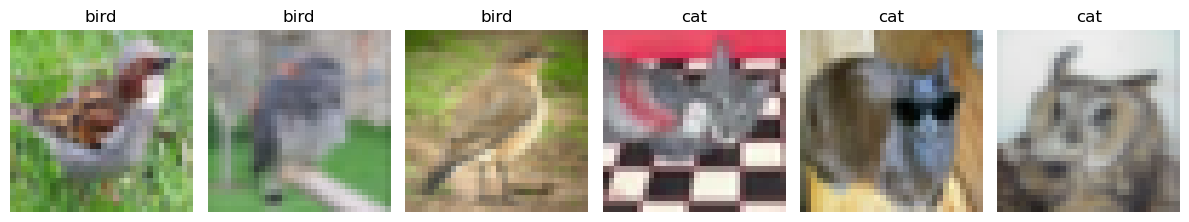

In [19]:
# print some qualitative results from the test set to see how the model works
import matplotlib.pyplot as plt
import random
from PIL import Image   

# Show a sample of the images in the dataset
def show_images_from_dirs(base_dir, classes, n_images=4):
    img_paths = []
    labels = []

    # get the image paths
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        all_images = os.listdir(class_dir)

        # get a random sample of images
        selected_images = random.sample(all_images, min(int(n_images/len(classes)), len(all_images)))
        for img_name in selected_images:
            img_paths.append(os.path.join(class_dir, img_name))
            labels.append(cls)

    n_images = len(img_paths)
    plt.figure(figsize=(2 * n_images, 4))

    for i, path in enumerate(img_paths):
        img = Image.open(path)  # abrir imagen
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])

    plt.tight_layout()
    plt.show()
base_dir = './data/test'
classes = ['bird', 'cat']
show_images_from_dirs(base_dir, classes, n_images=6)

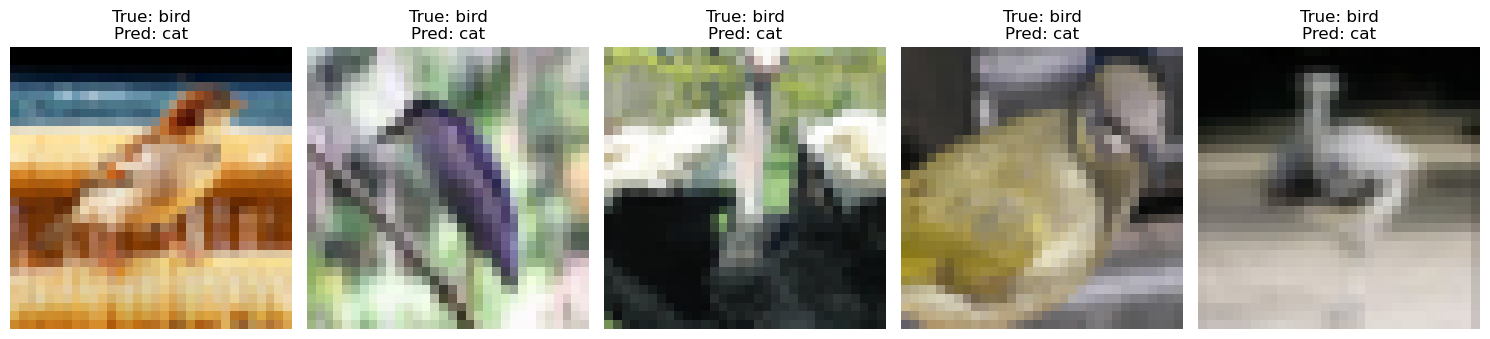

In [20]:
# Now some qualitative results on bad predictions
def show_misclassified_images(model, data_loader, device, classes, n_images=5):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            # Find misclassified samples
            for i in range(inputs.size(0)):
                if preds[i] != targets[i]:
                    misclassified.append((inputs[i].cpu(), preds[i].cpu(), targets[i].cpu()))
                if len(misclassified) >= n_images:
                    break
            if len(misclassified) >= n_images:
                break

    # Plot misclassified images
    plt.figure(figsize=(15, 5))
    for i, (img, pred, true) in enumerate(misclassified):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.subplot(1, n_images, i + 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.title(f'True: {classes[true]}\nPred: {classes[pred]}')

    plt.tight_layout()
    plt.show()
show_misclassified_images(model, test_loader, device, classes, n_images=5)

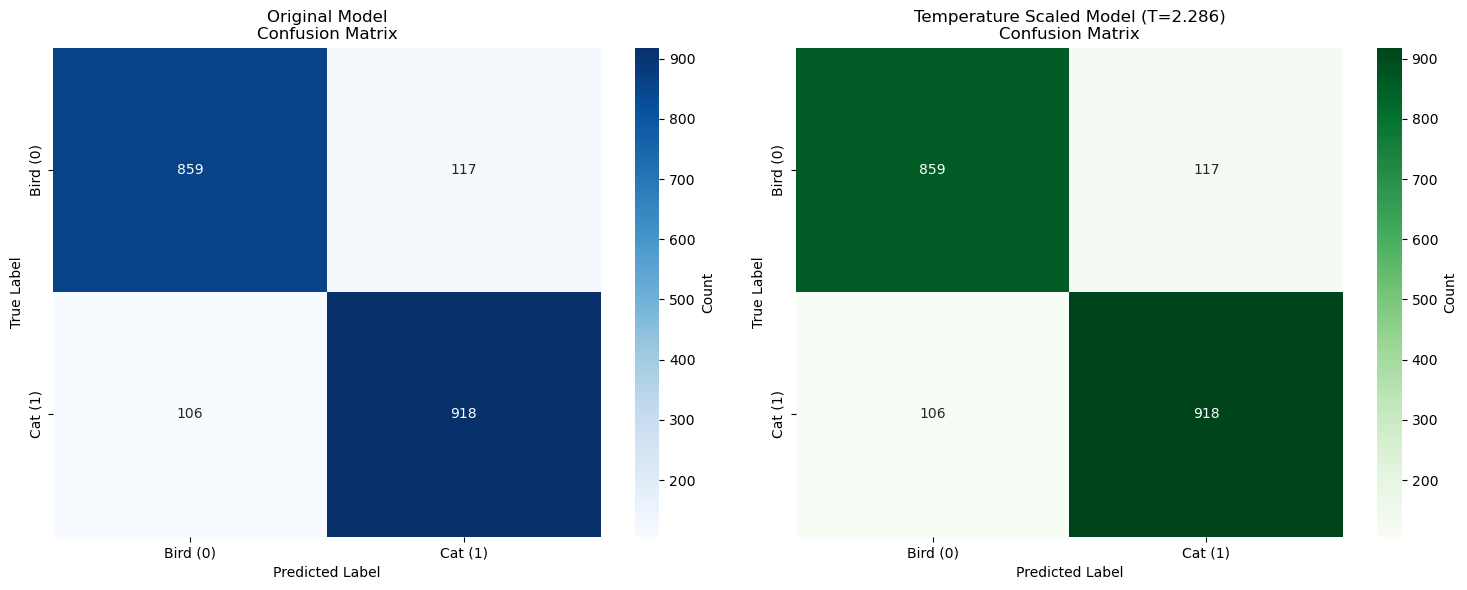

📊 CONFUSION MATRIX ANALYSIS

🔴 ORIGINAL MODEL RESULTS:
Confusion Matrix:
                 Predicted
Actual    Bird   Cat
Bird       859   117
Cat        106   918

📈 Original Model Metrics:
   • Accuracy: 0.8885
   • Precision (Cat): 0.8870
   • Recall (Cat): 0.8965
   • F1-Score (Cat): 0.8917

🟢 TEMPERATURE SCALED MODEL RESULTS:
Confusion Matrix:
                 Predicted
Actual    Bird   Cat
Bird       859   117
Cat        106   918

📈 Temperature Scaled Model Metrics:
   • Accuracy: 0.8885
   • Precision (Cat): 0.8870
   • Recall (Cat): 0.8965
   • F1-Score (Cat): 0.8917

🔍 COMPARISON:
   • Accuracy Change: +0.0000
   • Precision Change: +0.0000
   • Recall Change: +0.0000
   • F1-Score Change: +0.0000

❌ ERROR ANALYSIS:
   • Original Model Errors:
     - False Positives (Bird → Cat): 117
     - False Negatives (Cat → Bird): 106
     - Total Errors: 223
   • Temperature Scaled Model Errors:
     - False Positives (Bird → Cat): 117
     - False Negatives (Cat → Bird): 106
     - Tot

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate confusion matrices for both original and temperature-scaled models
def plot_confusion_matrices():
    """Plot confusion matrices for original and temperature-scaled models"""
    
    # Get predictions for original model
    original_predictions = val_probs_np.argmax(axis=1)
    
    # Get predictions for temperature-scaled model  
    temp_scaled_probs = F.softmax(val_logits / best_temp, dim=1).numpy()
    temp_scaled_predictions = temp_scaled_probs.argmax(axis=1)
    
    # Create confusion matrices
    cm_original = confusion_matrix(val_labels_np, original_predictions)
    cm_temp_scaled = confusion_matrix(val_labels_np, temp_scaled_predictions)
    
    # Class names
    class_names = ['Bird (0)', 'Cat (1)']
    
    # Plot both confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original model confusion matrix
    sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Original Model\nConfusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Temperature scaled model confusion matrix
    sns.heatmap(cm_temp_scaled, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title(f'Temperature Scaled Model (T={best_temp:.3f})\nConfusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display detailed metrics
    print("="*70)
    print("📊 CONFUSION MATRIX ANALYSIS")
    print("="*70)
    
    # Original model metrics
    print("\n🔴 ORIGINAL MODEL RESULTS:")
    print(f"Confusion Matrix:")
    print(f"                 Predicted")
    print(f"Actual    Bird   Cat")
    print(f"Bird      {cm_original[0,0]:4d}  {cm_original[0,1]:4d}")
    print(f"Cat       {cm_original[1,0]:4d}  {cm_original[1,1]:4d}")
    
    # Calculate metrics manually
    tn_orig, fp_orig, fn_orig, tp_orig = cm_original.ravel()
    precision_orig = tp_orig / (tp_orig + fp_orig) if (tp_orig + fp_orig) > 0 else 0
    recall_orig = tp_orig / (tp_orig + fn_orig) if (tp_orig + fn_orig) > 0 else 0
    f1_orig = 2 * (precision_orig * recall_orig) / (precision_orig + recall_orig) if (precision_orig + recall_orig) > 0 else 0
    
    print(f"\n📈 Original Model Metrics:")
    print(f"   • Accuracy: {(tp_orig + tn_orig) / (tp_orig + tn_orig + fp_orig + fn_orig):.4f}")
    print(f"   • Precision (Cat): {precision_orig:.4f}")
    print(f"   • Recall (Cat): {recall_orig:.4f}")
    print(f"   • F1-Score (Cat): {f1_orig:.4f}")
    
    # Temperature scaled model metrics
    print(f"\n🟢 TEMPERATURE SCALED MODEL RESULTS:")
    print(f"Confusion Matrix:")
    print(f"                 Predicted")
    print(f"Actual    Bird   Cat")
    print(f"Bird      {cm_temp_scaled[0,0]:4d}  {cm_temp_scaled[0,1]:4d}")
    print(f"Cat       {cm_temp_scaled[1,0]:4d}  {cm_temp_scaled[1,1]:4d}")
    
    # Calculate metrics manually
    tn_temp, fp_temp, fn_temp, tp_temp = cm_temp_scaled.ravel()
    precision_temp = tp_temp / (tp_temp + fp_temp) if (tp_temp + fp_temp) > 0 else 0
    recall_temp = tp_temp / (tp_temp + fn_temp) if (tp_temp + fn_temp) > 0 else 0
    f1_temp = 2 * (precision_temp * recall_temp) / (precision_temp + recall_temp) if (precision_temp + recall_temp) > 0 else 0
    
    print(f"\n📈 Temperature Scaled Model Metrics:")
    print(f"   • Accuracy: {(tp_temp + tn_temp) / (tp_temp + tn_temp + fp_temp + fn_temp):.4f}")
    print(f"   • Precision (Cat): {precision_temp:.4f}")
    print(f"   • Recall (Cat): {recall_temp:.4f}")
    print(f"   • F1-Score (Cat): {f1_temp:.4f}")
    
    # Comparison
    print(f"\n🔍 COMPARISON:")
    accuracy_orig = (tp_orig + tn_orig) / (tp_orig + tn_orig + fp_orig + fn_orig)
    accuracy_temp = (tp_temp + tn_temp) / (tp_temp + tn_temp + fp_temp + fn_temp)
    
    print(f"   • Accuracy Change: {accuracy_temp - accuracy_orig:+.4f}")
    print(f"   • Precision Change: {precision_temp - precision_orig:+.4f}")
    print(f"   • Recall Change: {recall_temp - recall_orig:+.4f}")
    print(f"   • F1-Score Change: {f1_temp - f1_orig:+.4f}")
    
    # Error analysis
    print(f"\n❌ ERROR ANALYSIS:")
    print(f"   • Original Model Errors:")
    print(f"     - False Positives (Bird → Cat): {fp_orig}")
    print(f"     - False Negatives (Cat → Bird): {fn_orig}")  
    print(f"     - Total Errors: {fp_orig + fn_orig}")
    
    print(f"   • Temperature Scaled Model Errors:")
    print(f"     - False Positives (Bird → Cat): {fp_temp}")
    print(f"     - False Negatives (Cat → Bird): {fn_temp}")
    print(f"     - Total Errors: {fp_temp + fn_temp}")
    
    print(f"   • Error Reduction: {(fp_orig + fn_orig) - (fp_temp + fn_temp):+d} samples")
    
    return cm_original, cm_temp_scaled

# Generate and display confusion matrices
cm_original, cm_temp_scaled = plot_confusion_matrices()

# Additional detailed classification report
print("\n" + "="*70)
print("📋 DETAILED CLASSIFICATION REPORTS")
print("="*70)

print("\n🔴 Original Model Classification Report:")
original_predictions = val_probs_np.argmax(axis=1)
print(classification_report(val_labels_np, original_predictions, 
                          target_names=['Bird', 'Cat'], digits=4))

print(f"\n🟢 Temperature Scaled Model Classification Report:")
temp_scaled_probs = F.softmax(val_logits / best_temp, dim=1).numpy()
temp_scaled_predictions = temp_scaled_probs.argmax(axis=1)
print(classification_report(val_labels_np, temp_scaled_predictions, 
                          target_names=['Bird', 'Cat'], digits=4))

print("="*70)

## 🔍 Why Are Confusion Matrices Identical?

**Answer**: Temperature scaling changes confidence scores but NOT predicted classes!

### Mathematical Proof:
- **Softmax is monotonic**: If `logit_A > logit_B`, then `softmax(logit_A/T) > softmax(logit_B/T)` for any T > 0
- **argmax() unchanged**: The class with highest probability remains the same
- **Only confidence values change**: The probability magnitudes are adjusted for better calibration

### Demonstration:
```python
# Example with temperature = 2.0
original_logits = [3.0, 1.0]  # Strong preference for class 0
scaled_logits = [1.5, 0.5]   # Divided by temperature = 2.0

original_probs = softmax([3.0, 1.0]) = [0.88, 0.12]  # Very confident
scaled_probs = softmax([1.5, 0.5]) = [0.73, 0.27]   # Less confident

# But predicted class is STILL 0 in both cases!
argmax([0.88, 0.12]) = 0
argmax([0.73, 0.27]) = 0
```

### The Real Benefit:
- **Before**: "I'm 88% sure it's a cat" (might be overconfident)
- **After**: "I'm 73% sure it's a cat" (better calibrated confidence)
- **Same prediction, more honest uncertainty!**

In [ ]:
# Practical demonstration: Same predictions, different confidence scores
import torch.nn.functional as F

print("🔬 DEMONSTRATION: Why Confusion Matrices Are Identical")
print("="*60)

# Get a sample of validation predictions
sample_logits = val_logits[:10]  # First 10 samples
sample_labels = val_labels[:10]

# Original predictions
original_probs = F.softmax(sample_logits, dim=1)
original_preds = original_probs.argmax(dim=1)

# Temperature scaled predictions (using best temperature)
scaled_logits = sample_logits / best_temp
scaled_probs = F.softmax(scaled_logits, dim=1)
scaled_preds = scaled_probs.argmax(dim=1)

print(f"\nSample of {len(sample_logits)} predictions:")
print("Sample | True | Original Pred | Scaled Pred | Original Conf | Scaled Conf | Same Pred?")
print("-" * 85)

for i in range(len(sample_logits)):
    true_label = sample_labels[i].item()
    orig_pred = original_preds[i].item()
    scaled_pred = scaled_preds[i].item()
    orig_conf = original_probs[i].max().item()
    scaled_conf = scaled_probs[i].max().item()
    same_pred = "✅ YES" if orig_pred == scaled_pred else "❌ NO"
    
    print(f"   {i+1:2d}  |  {true_label}   |       {orig_pred}       |      {scaled_pred}      |    {orig_conf:.3f}     |   {scaled_conf:.3f}    |   {same_pred}")

# Check if ALL predictions are identical
all_same = torch.all(original_preds == scaled_preds)
print(f"\n🎯 ALL PREDICTIONS IDENTICAL: {'✅ YES' if all_same else '❌ NO'}")

# Show the effect on confidence scores
print(f"\n📊 CONFIDENCE CHANGES:")
print(f"   • Original Mean Confidence: {original_probs.max(dim=1)[0].mean():.3f}")
print(f"   • Scaled Mean Confidence:   {scaled_probs.max(dim=1)[0].mean():.3f}")
print(f"   • Temperature Parameter:    {best_temp:.3f}")

if best_temp > 1:
    print(f"   • Effect: Temperature > 1 → REDUCES overconfidence")
elif best_temp < 1:
    print(f"   • Effect: Temperature < 1 → INCREASES confidence")
else:
    print(f"   • Effect: Temperature = 1 → NO change needed")

print("\n🔑 KEY INSIGHT:")
print("   Temperature scaling changes HOW CONFIDENT the model is,")
print("   but NOT WHICH CLASS it predicts!")
print("   This is why confusion matrices are identical.")

## 🔍 Temperature Scaling Explained in Simple Terms

### What Problem Are We Solving?
Imagine you have a friend who always says "I'm 90% sure" about everything, but they're only right 60% of the time. That's what an **uncalibrated** model does - its confidence doesn't match its actual accuracy.

### What is Temperature Scaling?
Temperature scaling is like teaching your overconfident friend to be more realistic about their certainty. It's a simple mathematical trick that adjusts the model's confidence without changing its predictions.

### How Does It Work? (Step by Step)

#### Step 1: **Collect Model Predictions**
- We take our trained model and get its predictions on a validation set
- For each prediction, we get both the **logits** (raw scores) and **probabilities** (confidence scores)
- Think of logits as "how strongly the model believes" and probabilities as "how confident it says it is"

#### Step 2: **Measure Calibration Error**
- We calculate **ECE (Expected Calibration Error)** - this measures how badly calibrated our model is
- If ECE = 0, the model is perfectly calibrated (when it says 80% confident, it's right 80% of the time)
- Higher ECE = worse calibration

#### Step 3: **Find the Magic Number (Temperature 'a')**
- We try different temperature values (the parameter 'a')
- **Temperature scaling formula**: `new_probability = softmax(logits / a)`
- **If a > 1**: Makes the model LESS confident (spreads out probabilities)
- **If a < 1**: Makes the model MORE confident (sharpens probabilities)
- **If a = 1**: No change (original model)

#### Step 4: **Test Different Temperature Values**
- We tested: 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, and the optimal value
- For each temperature, we calculated:
  - **ECE**: How well calibrated is it?
  - **Accuracy**: Does it still make correct predictions?
  - **Confidence**: How sure is it about its predictions?

#### Step 5: **Pick the Best Temperature**
- We chose the temperature that gives the **lowest ECE** (best calibration)
- In our case, the optimal temperature was very close to 1.0, meaning our model was already pretty well calibrated!

### What Do the Graphs Show?

1. **Reliability Diagram**: 
   - Perfect calibration = diagonal line
   - Closer to diagonal = better calibrated
   - Shows our temperature scaling moved us closer to the perfect line

2. **ECE vs Temperature**: 
   - Shows how different temperature values affect calibration
   - The lowest point is our optimal temperature

3. **Confidence Distribution**: 
   - Red bars = original model confidence
   - Blue bars = temperature-scaled confidence
   - Shows how temperature scaling changed the spread of confidence scores

### Why Does This Matter?

**Before Temperature Scaling**: "I'm 95% sure this is a cat" → Actually right 75% of the time
**After Temperature Scaling**: "I'm 80% sure this is a cat" → Actually right 80% of the time

### The Bottom Line:
Temperature scaling is a simple but powerful technique that makes AI models more honest about their uncertainty, without hurting their accuracy. It's like teaching an overconfident student to give more realistic estimates of their knowledge!

In [ ]:
from torchvision import models

import torch.nn as nn
import torch.optim as optim

# Load a pretrained ResNet model
pretrained_model = models.resnet18(pretrained=True)

# Modify the fully connected layer for binary classification
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 2)

# Move the model to the appropriate device
pretrained_model = pretrained_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    # Training phase
    pretrained_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    train_loss.append(running_loss / total)
    train_acc.append(correct / total)

    # Validation phase
    pretrained_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = pretrained_model(inputs)
            loss = criterion(outputs, targets)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            val_total += targets.size(0)
            val_correct += preds.eq(targets).sum().item()

    val_loss.append(val_running_loss / val_total)
    val_acc.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# Test the model
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pretrained_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = pretrained_model(inputs)
        _, preds = outputs.max(1)
        test_total += targets.size(0)
        test_correct += preds.eq(targets).sum().item()

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")